In [1]:
import time
import picamera
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
#%config InlineBackend.figure_format = "svg"
import sys
sys.path.append("..")
import SHSlib  as sh
import cv2 as cv
%load_ext autoreload
%autoreload 2

# Capture Data for later analyses

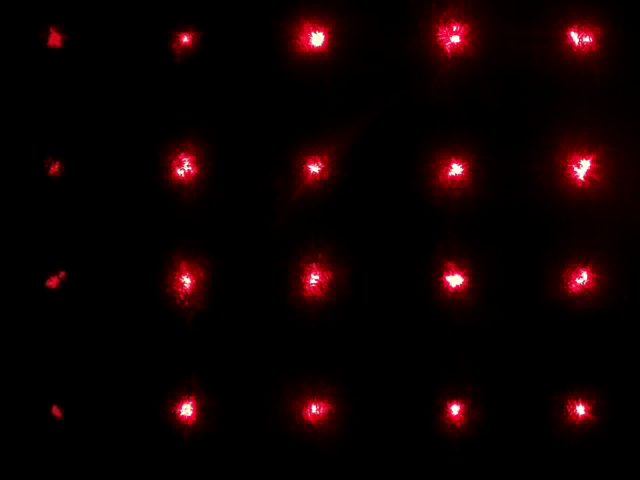

KeyboardInterrupt: 

In [42]:


List_of_Images = []

with picamera.PiCamera(
        sensor_mode= 4,  # 1640x1232, full FoV, binning 2x2
        resolution= (640,480),
        #resolution= (2028,1524),
        framerate= 90
) as camera:
    time.sleep(1)  # let the camera warm up and set gain/white balance
    camera.exposure_mode = 'off'
    camera.awb_mode = 'off'
    camera.awb_gains = 2
    camera.shutter_speed = int(6e5)
    camera.iso = 1
    output = np.zeros((480,640,3), dtype=np.uint8)
    t1 = time.time_ns()
    for i in range(100000): 
        camera.capture(output,'rgb',use_video_port=True)
        img = output.astype(np.uint16)
        
        List_of_Images += [output]
        
        for j in range(10):
            camera.capture(output,'rgb',use_video_port=True)
            img += Image.fromarray(output,'RGB')
        
        img = (img/11).astype(np.uint8)
        img = Image.fromarray(img,'RGB')
        
        
        t2 = time.time_ns()
        display(img,clear=True)    
    t2 = time.time_ns()
    print(50/((t2 - t1)/1e9))

In [ ]:
# Save data 
import pickle 
filename = "TypeDataName.pickle"
with open(filename,'wb') as f:
    pickle.dump(List_of_Images,f)

## Live Plot some Analyses 

<IPython.core.display.Javascript object>


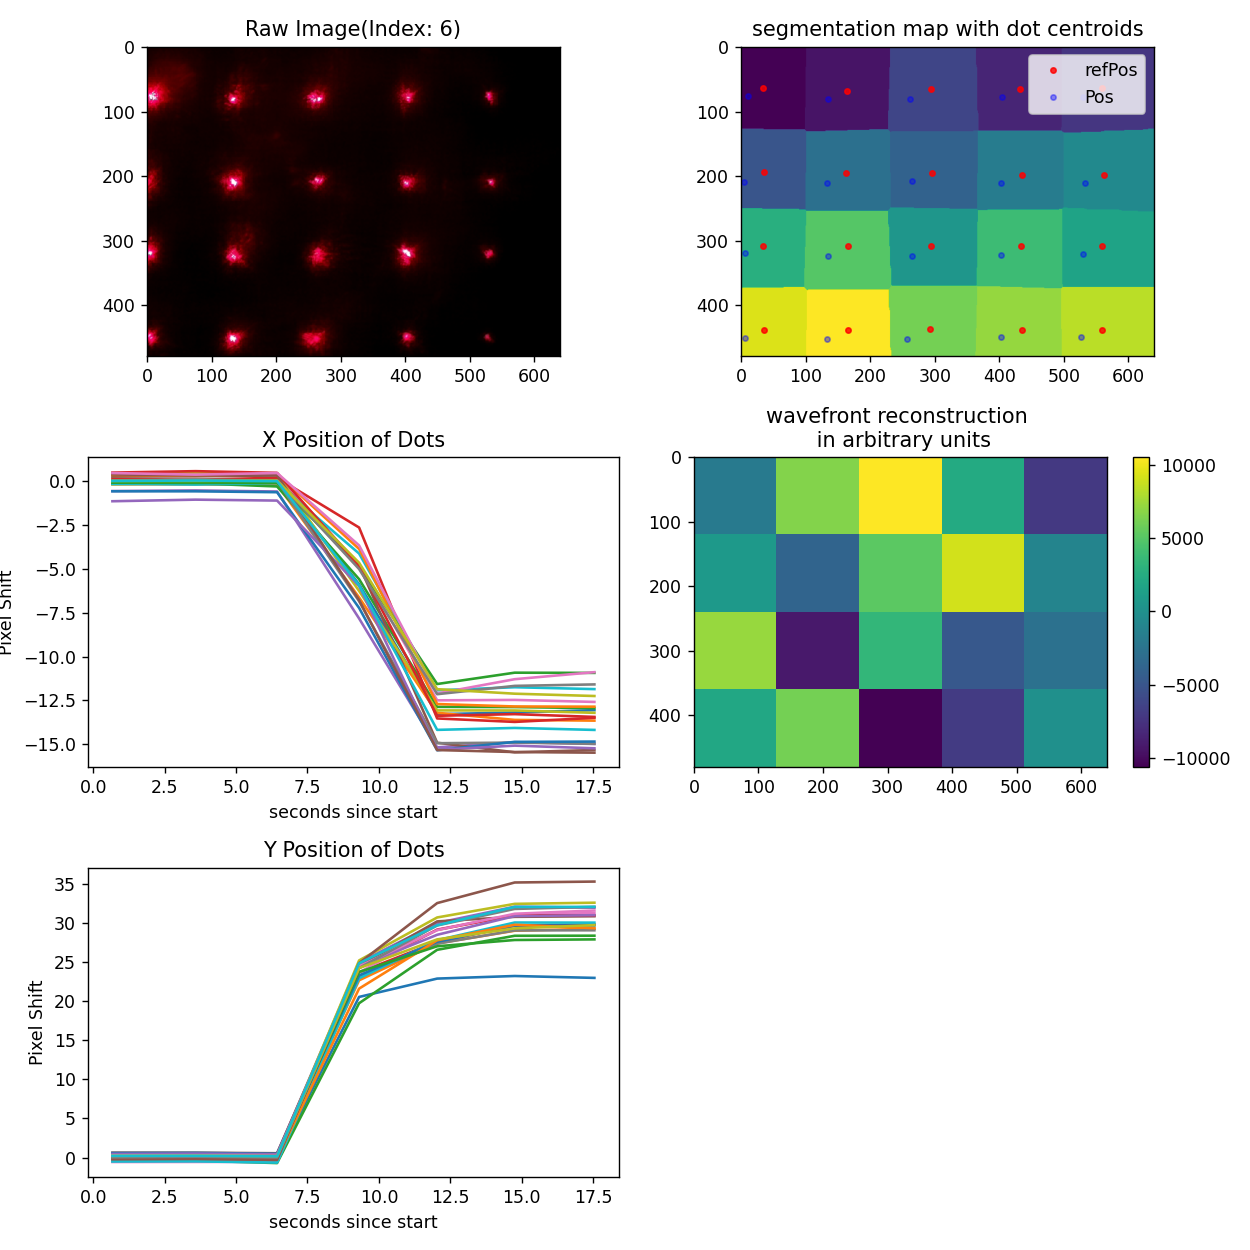

KeyboardInterrupt: 

In [41]:

indx = 0 
resolution = (640,480)
#resolution = (1280,720)
#resolution = (1640,1232)
#resolution =(2016, 1520)

min_distance = 30

indx_end = 1000

#try:
with picamera.PiCamera(
    # Camera Setup 
    sensor_mode= 4,  
    resolution= resolution,
    framerate= 30
) as camera:
    # addition camera setup
    time.sleep(1)  # let the camera warm up and set gain/white balance
    camera.exposure_mode = 'off'
    camera.awb_mode = 'off'
    camera.awb_gains = 2.5

    camera.shutter_speed = int(6e6)
    camera.iso = 50
    output = np.zeros((*reversed(resolution),3), dtype=np.uint8)

    # -- get ref image
    for i in range(5):
        camera.capture(output,'rgb',use_video_port=True)
    
    PIL_ref_img = Image.fromarray(output,'RGB')
    ref_img = np.mean(PIL_ref_img,2) 
    ref_img = cv.blur(ref_img,(5,5))
    ref_img[ref_img < 40] = 0
    
    # -- process ref image
    ref_lables = sh.analyse.getSeperation(ref_img,min_distance=min_distance)
    ref_center = sh.analyse.getMomentum(ref_lables,ref_img, algorythm="C") 
    ShiftOverTimeX = np.zeros((len(ref_center[0]),indx_end))
    ShiftOverTimeY = np.zeros((len(ref_center[0]),indx_end))
    
    timeOfCapture = np.zeros(indx_end)
    timeOfCapture[0] = 0

    # -- create Plot
    fig = plt.figure(figsize=(10,10))
    axSensor = fig.add_subplot(321)
    axPeakArea = fig.add_subplot(322)
    axIntegraion = fig.add_subplot(324)
    
    imageIntegraion = axIntegraion.imshow(PIL_ref_img)
    imageIntegraionColourbar = plt.colorbar(imageIntegraion)
    imageIntegraion.set_clim(-1500,1500)
    axIntegraion.set_title("wavefront reconstruction \n in arbitrary units")
    
    axPeakPosOverTime = fig.add_subplot(323)
    axPeakPosOverTime.set_title("X Position of Dots")
    axPeakPosOverTime.set_ylabel("Pixel Shift")
    axPeakPosOverTime.set_xlabel("seconds since start")
    
    axPeakPosOverTime2 = fig.add_subplot(325)
    axPeakPosOverTime2.set_title("Y Position of Dots")
    axPeakPosOverTime2.set_ylabel("Pixel Shift")
    axPeakPosOverTime2.set_xlabel("seconds since start")
    
    imageSensorImg =  axSensor.imshow(PIL_ref_img)
    
    imagePeakArea = axPeakArea.imshow(ref_lables)
    linePeakPoints1 = axPeakArea.plot(ref_center[0],ref_center[1],"r.",label='refPos',linewidth=0.01,alpha=0.8)
    linePeakPoints2 = axPeakArea.plot(ref_center[0],ref_center[1],"b.",label='Pos',linewidth=0.01,alpha=0.4)
    axPeakArea.set_title("segmentation map with dot centroids")
    #axSensor.set_title
    axPeakArea.legend()

    linePeakPosOverXTime = []
    linePeakPosOverYTime = []
    for i in range(len(ref_center[0])):
        linePeakPosOverXTime += [axPeakPosOverTime.plot(ref_center[0][i])]
        linePeakPosOverYTime += [axPeakPosOverTime2.plot(ref_center[1][i])]
    fig.canvas.draw()
    plt.show()

    t0 = time.time_ns()

    # Constuct Transformation Matrix "D" to be used with Gradientdatat G
    # the samplepositon for integration is equal for to the position of dots
    D = sh.analyse.getIntegration(ref_center[0]*1.5e-6,ref_center[1]*1.5e-6,ref_center[0]*1.5e-6,ref_center[1]*1.5e-6,NPartner =7 )
    D = sh.analyse.getIntegration(ref_center[0],ref_center[1],ref_center[0],ref_center[1],NPartner =7 )
    
    plt.tight_layout()
    
    for i in range(0,indx_end):
        t1 = time.time_ns()
        # continuous capture 
        camera.capture(output,'rgb',use_video_port=True) # 50ms
        timeOfCapture[i] = (time.time_ns() - t0) /1e9

        Sensor_img = Image.fromarray(output,'RGB') #5ms

        img = np.int16(output)
        img = np.uint8((img[:,:,0] + img[:,:,1] + img[:,:,2])/3)
        img[img < 60] = 0
        #%time img = np.mean(Sensor_img,2)

        center = sh.analyse.getMomentum(ref_lables, img, algorythm="C") 
        partners = sh.analyse.getPartner(center, ref_center)
        dx = partners[0]
        dy = partners[1]

        ShiftOverTimeX[:,i] = dx
        ShiftOverTimeY[:,i] = dy

        
        klein_Z = np.sqrt(dx**2 +dy**2)
        #G = np.concatenate(klein_Z/[partners[0],klein_Z/partners[1]])
        #G = np.concatenate([dx*1.5e-6,dy*1.5e-6])
        G = np.concatenate([dx,dy])
        Z2 = np.linalg.lstsq(D,G,rcond=None)[0]
        
        if i//2 ==0:
            Z = Z2[0:-1].reshape(4,5)
        else:
            Z = Z2[1::].reshape(4,5)
        
        
        #print((time.time_ns() - t1)/1e6)
        if True: #i%0 == 0:
            # Set data for Ploting
            imageSensorImg.set_data(Sensor_img) 

            imageIntegraion.set_data(Z)
            axIntegraion.relim()
            axIntegraion.autoscale_view(True,True,True) 
            imageIntegraion.autoscale()
            #plt.colorbar(imageIntegraion)
            #imagePeakArea.set_data(img)

            linePeakPoints2[0].set_xdata(center[0])
            linePeakPoints2[0].set_ydata(center[1])
            axSensor.set_title("Raw Image(Index: " + str(indx) +")")
            
#             if indx == 5:
#                 fig.savefig("i5.png",dpi=400)
#             if indx == 20:
#                 fig.savefig("i20.png",dpi=400)
#             if indx == 40:
#                 fig.savefig("i40.png",dpi=400)
                
            for j in range(len(ShiftOverTimeX[:,i])):
                linePeakPosOverYTime[j][0].set_ydata(ShiftOverTimeX[j,0:i+1])
                linePeakPosOverYTime[j][0].set_xdata(timeOfCapture[0:i+1])

                linePeakPosOverXTime[j][0].set_ydata(ShiftOverTimeY[j,0:i+1])
                linePeakPosOverXTime[j][0].set_xdata(timeOfCapture[0:i+1])

                axPeakPosOverTime.relim() 
                axPeakPosOverTime.autoscale_view(True,True,True) 

                axPeakPosOverTime2.autoscale_view(True,True,True) 
                axPeakPosOverTime2.relim() 
            fig.canvas.draw()
        indx += 1 
#except Exception:
 #   print("")